In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from scipy.optimize import minimize

from statsmodels.tsa.arima.model import ARIMA

In [4]:
data = pd.read_csv('Case 2 Data 2024.csv', index_col = 0)
print(data)
y = data

'''
We recommend that you change your train and test split
'''
TRAIN, TEST = train_test_split(data, test_size = 0.2, shuffle = False)

               A           B           C           D           E           F
0     100.000000  100.000000  100.000000  100.000000  100.000000  100.000000
1     101.804962   95.006117  100.620233  101.093750  100.232262   97.859860
2     104.326358   91.632940  101.798739  102.185390  100.689872   94.990233
3     104.509559   90.577894  103.731466  101.599475   99.583998   93.790650
4     104.750542   92.571924  102.430303  102.856094  101.847549   95.003278
...          ...         ...         ...         ...         ...         ...
2515  284.655029   29.642872  120.905989  136.780215  218.809939  206.815478
2516  277.884584   30.152992  116.312490  136.625183  217.821692  208.061079
2517  276.762248   30.062651  113.076450  140.483922  216.676890  209.369286
2518  270.631786   30.528208  113.388009  140.757562  222.930945  212.475576
2519  274.462442   30.614156  112.960522  141.911418  222.404291  213.128083

[2520 rows x 6 columns]


# **Different Methods**

## HRP OPTIMIZATION:

Sharpe ratio:  1.1468603945381197

In [5]:
# HRP OPTIMIZATION: Sharpe ratio:  1.1468603945381197
from scipy.spatial.distance import squareform
k = -1
counter = 0

window = 252*18

class Allocator():
    def __init__(self, train_data):
        '''
        Anything data you want to store between days must be stored in a class field
        '''

        self.running_price_paths = train_data.copy()

        self.train_data = train_data.copy()

        # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data

    def hrp_optimizer(self, covariance_matrix, k, returns_df):
        # Step 1: Calculate the Correlation Matrix
        correlation_matrix = covariance_matrix.corr()

        # Step 2: Calculate the Distance Matrix
        distance_matrix = np.sqrt(0.5 * (1 - correlation_matrix))
        # Convert the distance matrix to condensed form
        condensed_distance_matrix = squareform(distance_matrix)

        # Step 3: Calculate the Linkage Matrix
        linkage_matrix = scipy.cluster.hierarchy.linkage(condensed_distance_matrix, 'centroid')

        # Step 4: Calculate the Cluster Assignments
        cluster_assignments = scipy.cluster.hierarchy.fcluster(linkage_matrix, k, criterion='inconsistent')

        # Step 5: Calculate the Inverse Variance Portfolios
        ivp = 1 / np.diag(covariance_matrix)
        ivp /= ivp.sum()

        # Step 6: Calculate the Hierarchical Risk Parity Portfolio Weights
        hrp_weights = pd.Series(index=covariance_matrix.columns, dtype=np.float64)
        for cluster_id in np.unique(cluster_assignments):
            cluster_indices = np.where(cluster_assignments == cluster_id)[0]
            cluster_covariance = covariance_matrix.iloc[cluster_indices, cluster_indices]
            cluster_ivp = ivp[cluster_indices]
            cluster_weight = cluster_ivp / np.sum(cluster_ivp)
            hrp_weights[cluster_covariance.index] = cluster_weight
        hrp_weights /= hrp_weights.sum()

        # Step 7: Calculate the Portfolio Statistics
        portfolio_returns = (hrp_weights * returns_df.mean()).sum()
        portfolio_volatility = np.sqrt(np.dot(hrp_weights.T, np.dot(covariance_matrix, hrp_weights)))
        portfolio_sharpe_ratio = portfolio_returns / portfolio_volatility

        return hrp_weights, portfolio_sharpe_ratio, portfolio_returns

    def allocate_portfolio(self, asset_prices):
        '''
        asset_prices: np array of length 6, prices of the 6 assets on a particular day
        weights: np array of length 6, portfolio allocation for the next day
        '''
        global data, daily_returns, k, counter, window

        data = pd.concat([data.iloc[-window:, :], pd.Series(asset_prices, index=data.columns).to_frame().T], axis=0)

        daily_returns = data.pct_change()


        # Step 1: Calculate the Covariance Matrix
        cov_matrix = daily_returns.cov()

        if k == -1:
            k_values = range(1,6)

            best_sharpe_ratio = -np.inf
            best_k = None
            best_weights = None
            for k in k_values:
                hrp_weights, portfolio_sharpe_ratio, portfolio_returns = self.hrp_optimizer(cov_matrix, k, daily_returns)
                if portfolio_sharpe_ratio > best_sharpe_ratio:
                    best_sharpe_ratio = portfolio_sharpe_ratio
                    best_k = k
            k = best_k

        weights, _, _ = self.hrp_optimizer(cov_matrix, k, daily_returns)

        print(counter)
        counter += 1
        return weights

## APPLYING RPA WEIGHTS AND MARKOWITZ WEIGHTS

Sharpe ratio:  1.1250141601119237

In [6]:
# # APPLYING RPA DIRECTLY ONTO MARKOWITZ WEIGHTS

# import numpy as np
# from scipy.optimize import minimize

# class Allocator():
#     def __init__(self, train_data):
#         '''
#         Anything data you want to store between days must be stored in a class field
#         '''

#         self.running_price_paths = pd.DataFrame(train_data.copy())

#         self.train_data = train_data.copy()

#         # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data


#     def allocate_portfolio(self, asset_prices):
#         '''
#         asset_prices: np array of length 6, prices of the 6 assets on a particular day
#         weights: np array of length 6, portfolio allocation for the next day
#         '''
#         self.running_price_paths.loc[len(self.running_price_paths)] = asset_prices

#         ### TODO Implement your code here
#         # weights = np.array([0,1,-1,0.5,0.1,-0.2])

#         # EQUAL WEIGHT METHOD
#         num_stocks = self.train_data.shape[1]
#         weights = np.ones(num_stocks) / num_stocks
#         self.asset_returns = self.running_price_paths.pct_change().dropna()
#         blend_factor = 0.5  # Adjust blend factor as needed
#         rp_weights = self._allocate_risk_parity(asset_prices)
#         mw_weights = self._allocate_markowitz(asset_prices)

#         weights = blend_factor * rp_weights + (1 - blend_factor) * mw_weights
#         return weights

#     def _allocate_risk_parity(self, asset_prices):
#         '''
#         Allocate weights using Risk Parity strategy.
#         '''

#         asset_covariance = np.cov(self.asset_returns.T)
#         if asset_covariance.size == 0 or len(asset_covariance.shape) != 2:
#             raise ValueError("Covariance matrix is empty or has unexpected dimensions.")
#         # Calculate inverse diagonal volatility
#         inv_diag_vol = 1 / np.sqrt(np.diag(asset_covariance))
#         # Calculate weights
#         weights = inv_diag_vol / np.sum(inv_diag_vol)
#         return weights

#     def _allocate_markowitz(self, asset_prices):
#         '''
#         Allocate weights using Markowitz strategy (random weights for demonstration).
#         '''
#         asset_covariance = np.cov(self.asset_returns.T)
#         num_assets = len(asset_covariance)

#         def markowitz_objective(weights, cov_matrix):
#             portfolio_volatility = np.sqrt(np.matmul(weights.T, np.matmul(cov_matrix, weights)))
#             return portfolio_volatility

#         constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Sum of weights = 1
#         init_weights = np.ones(num_assets) / num_assets  # Initialize weights

#         # Run optimization
#         result = minimize(markowitz_objective, init_weights, args=(asset_covariance,),
#                           method='SLSQP', constraints=constraints)

#         # Get optimal weights
#         weights = result.x

#         weights = weights / np.sum(weights)
#         return weights

## KERAS NN

In [7]:
## KERAS NN

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout

# class Allocator():
#     def __init__(self, train_data):
#         self.running_price_paths = pd.DataFrame(train_data.copy())
#         self.train_data = train_data.copy()
#         self.asset_returns = self.running_price_paths.pct_change().dropna()

#     def create_model(self):
#         model = Sequential([
#             Dense(64, activation='relu', input_shape=(self.train_data.shape[1],)),
#             Dropout(0.2),  # Add dropout layer with 20% dropout rate
#             Dense(32, activation='relu'),
#             Dropout(0.2),  # Add dropout layer with 20% dropout rate
#             Dense(self.train_data.shape[1], activation='linear')  # Change softmax to linear
#         ])
#         model.compile(optimizer='adam', loss='mse')
#         return model

#     def train_model(self, model, X_train, y_train):
#         model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)

#     def allocate_portfolio(self, asset_prices, blend_factor=0.5):
#         self.running_price_paths.loc[len(self.running_price_paths)] = asset_prices

#         # Generate initial weights using Markowitz and RPA
#         mw_weights = self._allocate_markowitz(asset_prices)
#         rp_weights = self._allocate_risk_parity(asset_prices)

#         # Combine initial weights
#         initial_weights = blend_factor * mw_weights + (1 - blend_factor) * rp_weights

#         # Prepare data for training
#         X_train = self.running_price_paths.values[:-1]
#         y_train = self.running_price_paths.values[1:]

#         # Convert asset_prices to a NumPy array and reshape
#         asset_prices_array = np.array(asset_prices).reshape(1, -1)

#         # Create and train the model
#         model = self.create_model()
#         self.train_model(model, X_train, y_train)

#         # Predict portfolio weights
#         predicted_weights = model.predict(asset_prices_array)[0]

#         return predicted_weights / np.sum(np.abs(predicted_weights))

#     def _allocate_risk_parity(self, asset_prices):
#         '''
#         Allocate weights using Risk Parity strategy.
#         '''

#         asset_covariance = np.cov(self.asset_returns.T)
#         if asset_covariance.size == 0 or len(asset_covariance.shape) != 2:
#             raise ValueError("Covariance matrix is empty or has unexpected dimensions.")
#         # Calculate inverse diagonal volatility
#         inv_diag_vol = 1 / np.sqrt(np.diag(asset_covariance))
#         # Calculate weights
#         weights = inv_diag_vol / np.sum(inv_diag_vol)
#         return weights

#     def _allocate_markowitz(self, asset_prices):
#         # '''
#         # Allocate weights using Markowitz strategy (random weights for demonstration).
#         # '''
#         # asset_covariance = np.cov(self.asset_returns.T)
#         # num_assets = len(asset_covariance)
#         # weights = np.random.random(num_assets)
#         # weights /= np.sum(weights)

#         # return weights
#         '''
#         Allocate weights using Markowitz strategy.
#         '''
#         asset_covariance = np.cov(self.asset_returns.T)
#         num_assets = len(asset_covariance)

#         def markowitz_objective(weights, cov_matrix):
#             portfolio_volatility = np.sqrt(np.matmul(weights.T, np.matmul(cov_matrix, weights)))
#             return portfolio_volatility

#         constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Sum of weights = 1
#         init_weights = np.ones(num_assets) / num_assets  # Initialize weights

#         # Run optimization
#         result = minimize(markowitz_objective, init_weights, args=(asset_covariance,),
#                           method='SLSQP', constraints=constraints)

#         # Get optimal weights
#         weights = result.x

#         weights = weights / np.sum(weights)
#         return weights

## APPLYING RPA DIRECTLY ONTO MARKOWITZ WEIGHTS

Sharpe ratio:  1.0200029420496408

In [8]:
# # APPLYING RPA DIRECTLY ONTO MARKOWITZ WEIGHTS

# import numpy as np
# from scipy.optimize import minimize

# class Allocator():
#     def __init__(self, train_data):
#         '''
#         Anything data you want to store between days must be stored in a class field
#         '''
#         self.running_price_paths = pd.DataFrame(train_data.copy())
#         self.train_data = train_data.copy()
#         self.asset_returns = self.running_price_paths.pct_change().dropna()

#     def allocate_portfolio(self, asset_prices, blend_factor=0.5):
#         '''
#         asset_prices: np array of length 6, prices of the 6 assets on a particular day
#         weights: np array of length 6, portfolio allocation for the next day
#         '''
#         self.running_price_paths.loc[len(self.running_price_paths)] = asset_prices

#         ### TODO Implement your code here
#         # weights = np.array([0,1,-1,0.5,0.1,-0.2])

#         # EQUAL WEIGHT METHOD
#         num_stocks = self.train_data.shape[1]
#         weights = np.ones(num_stocks) / num_stocks
#         self.asset_returns = self.running_price_paths.pct_change().dropna()
#         mw_weights = self._allocate_markowitz(asset_prices)
#         # Calculate covariance matrix from historical returns
#         asset_covariance = np.cov(self.asset_returns.T)

#         # Apply Risk Parity Allocation (RPA) directly on Markowitz weights
#         rp_weights = np.multiply(mw_weights, (mw_weights @ asset_covariance)) / np.sqrt(np.abs(mw_weights @ asset_covariance @ mw_weights.T))
#         rp_weights = np.array(rp_weights)

#         weights = blend_factor*mw_weights + (1-blend_factor)*rp_weights
#         weights = weights / np.sum(weights)
#         return weights

#     def _allocate_markowitz(self, asset_prices):
#         '''
#         Allocate weights using Markowitz strategy.
#         '''
#         asset_covariance = np.cov(self.asset_returns.T)
#         num_assets = len(asset_covariance)

#         def markowitz_objective(weights, cov_matrix):
#             portfolio_volatility = np.sqrt(np.matmul(weights.T, np.matmul(cov_matrix, weights)))
#             return portfolio_volatility

#         constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Sum of weights = 1
#         init_weights = np.ones(num_assets) / num_assets  # Initialize weights

#         # Run optimization
#         result = minimize(markowitz_objective, init_weights, args=(asset_covariance,),
#                           method='SLSQP', constraints=constraints)

#         # Get optimal weights
#         weights = result.x

#         weights = weights / np.sum(weights)
#         return weights

#     # def _sharpe_ratio_objective(self, weights, returns, cov_matrix, risk_free_rate=0.0):
#     #     portfolio_returns = np.dot(weights, returns.mean())
#     #     portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
#     #     sharpe_ratio = (portfolio_returns - risk_free_rate) / portfolio_volatility
#     #     return -sharpe_ratio  # Minimize the negative Sharpe ratio for maximization

#     # def _allocate_markowitz(self, asset_prices):
#     #     '''
#     #     Allocate weights using Markowitz strategy with optimization to maximize Sharpe ratio.
#     #     '''
#     #     asset_returns = self.running_price_paths.pct_change().dropna()
#     #     asset_covariance = np.cov(asset_returns.T)
#     #     num_assets = len(asset_covariance)

#     #     constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights = 1 constraint
#     #                    {'type': 'ineq', 'fun': lambda x: x})  # Non-negative weights constraint
#     #     init_weights = np.ones(num_assets) / num_assets  # Initialize weights

#     #     # Run optimization to maximize Sharpe ratio
#     #     result = minimize(self._sharpe_ratio_objective, init_weights, args=(asset_returns, asset_covariance),
#     #                       method='SLSQP', constraints=constraints)

#     #     # Get optimal weights
#     #     weights = result.x
#     #     weights /= np.sum(weights)  # Normalize weights to sum up to 1
#     #     return weights

## ARIMA (incomplete)

In [9]:
## ARIMA (incomplete)

# train_size = int(0.8 * len(data))
# X_train, X_test = data[:train_size], data[train_size:]
# y_train, y_test = data[:train_size], data[train_size:]
# print(X_train)
# models = []
# for column in y.columns:
#     model = ARIMA(y_train[column], order=(1, 1, 1))  # Example order, adjust as needed
#     model_fit = model.fit()
#     models.append(model_fit)

# # Make predictions for the next year
# predictions = []
# for model in models:
#     forecast = model.forecast(steps=len(X_test))
#     predictions.append(forecast)

# print(predictions)

# class Allocator():
#     def __init__(self, train_data):
#         '''
#         Anything data you want to store between days must be stored in a class field
#         '''

#         self.running_price_paths = pd.DataFrame(train_data.copy())

#         self.train_data = train_data.copy()
#         self.y = train_data.copy()

#         # Do any preprocessing here -- do not touch running_price_paths, it will store the price path up to that data

#     def create_additional_features(self, stock_data):
#         """
#         Creates additional features for the stock data, such as moving averages
#         :param stock_data: Dataset to create features for
#         :return: pandas Dataframe with columns for moving averages
#         """
#         df = pd.DataFrame(stock_data)
#         df['5d_rolling_avg'] = stock_data.rolling(window=5).mean()
#         df['10d_rolling_avg'] = stock_data.rolling(window=10).mean()
#         # Add more features as needed
#         return df

#     def train_model(self, model, X_train, y_train):
#         """
#         Trains the given model
#         :param model: model to train
#         :param X_train: features to train the model off of
#         :param y_train: target values corresponding to X_train
#         :return: trained model
#         """
#         model.fit(X_train, y_train)
#         return model

#     def get_model_confidence(self, model, X_test, y_test):
#         """
#         Calculates the confidence in the model based on its performance.
#         :param model: Trained machine learning model.
#         :param DataFrame X_test: Test features.
#         :param Series y_test: True values for the test set.
#         :return: A confidence score for the model.
#         """
#         # Using the model's R-squared value as confidence
#         r_squared = model.score(X_test, y_test)
#         return r_squared


#     def allocate_portfolio(self, asset_prices):
#         '''
#         asset_prices: np array of length 6, prices of the 6 assets on a particular day
#         weights: np array of length 6, portfolio allocation for the next day
#         '''
#         self.running_price_paths.loc[len(self.running_price_paths)] = asset_prices
#         #ml_stock_data_with_features = self.create_additional_features(self.running_price_paths)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#         print(X_train, y_train)
#         ### TODO Implement your code here
#         # weights = np.array([0,1,-1,0.5,0.1,-0.2])

#         # EQUAL WEIGHT METHOD
#         num_stocks = self.train_data.shape[1]
#         weights = np.ones(num_stocks) / num_stocks
#         self.asset_returns = self.running_price_paths.pct_change().dropna()
#         blend_factor = 0.97  # Adjust blend factor as needed
#         rp_weights = self._allocate_risk_parity(asset_prices)
#         mw_weights = self._allocate_markowitz(asset_prices)

#         weights = blend_factor * rp_weights + (1 - blend_factor) * mw_weights
#         return weights

#     def _allocate_risk_parity(self, asset_prices):
#         '''
#         Allocate weights using Risk Parity strategy.
#         '''

#         asset_covariance = np.cov(self.asset_returns.T)
#         if asset_covariance.size == 0 or len(asset_covariance.shape) != 2:
#             raise ValueError("Covariance matrix is empty or has unexpected dimensions.")
#         # Calculate inverse diagonal volatility
#         inv_diag_vol = 1 / np.sqrt(np.diag(asset_covariance))
#         # Calculate weights
#         weights = inv_diag_vol / np.sum(inv_diag_vol)
#         return weights

#     def _allocate_markowitz(self, asset_prices):
#         # '''
#         # Allocate weights using Markowitz strategy (random weights for demonstration).
#         # '''
#         # asset_covariance = np.cov(self.asset_returns.T)
#         # num_assets = len(asset_covariance)
#         # weights = np.random.random(num_assets)
#         # weights /= np.sum(weights)

#         # return weights
#         '''
#         Allocate weights using Markowitz strategy.
#         '''
#         asset_covariance = np.cov(self.asset_returns.T)
#         num_assets = len(asset_covariance)

#         def markowitz_objective(weights, cov_matrix):
#             portfolio_volatility = np.sqrt(np.matmul(weights.T, np.matmul(cov_matrix, weights)))
#             return portfolio_volatility

#         constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Sum of weights = 1
#         init_weights = np.ones(num_assets) / num_assets  # Initialize weights

#         # Run optimization
#         result = minimize(markowitz_objective, init_weights, args=(asset_covariance,),
#                           method='SLSQP', constraints=constraints)

#         # Get optimal weights
#         weights = result.x

#         weights = weights / np.sum(weights)
#         return weights


## LINEAR REGRESSION SCIPY

Sharpe ratio:  0.6137998351901575

In [10]:
# import numpy as np
# import pandas as pd
# from scipy.optimize import minimize
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split

# class Allocator():
#     def __init__(self, train_data):
#         self.running_price_paths = pd.DataFrame(train_data.copy())
#         self.train_data = train_data.copy()
#         self.asset_returns = self.running_price_paths.pct_change().dropna()

#     def allocate_portfolio(self, asset_prices, blend_factor=0.97):
#         self.running_price_paths.loc[len(self.running_price_paths)] = asset_prices

#         # Generate initial weights using Markowitz and RPA
#         mw_weights = self._allocate_markowitz(asset_prices)
#         rp_weights = self._allocate_risk_parity(asset_prices)

#         # Combine initial weights
#         initial_weights = blend_factor * mw_weights + (1 - blend_factor) * rp_weights

#         # Prepare data for training
#         X_train = self.running_price_paths.values[:-1]
#         y_train = self.running_price_paths.values[1:]

#         # Train linear regression model
#         model = LinearRegression()
#         model.fit(X_train, y_train)

#         # Predict portfolio weights
#         predicted_weights = model.predict(np.array(asset_prices).reshape(1, -1))[0]

#         return predicted_weights / np.sum(np.abs(predicted_weights))

#     def _allocate_risk_parity(self, asset_prices):
#         '''
#         Allocate weights using Risk Parity strategy.
#         '''

#         asset_covariance = np.cov(self.asset_returns.T)
#         if asset_covariance.size == 0 or len(asset_covariance.shape) != 2:
#             raise ValueError("Covariance matrix is empty or has unexpected dimensions.")
#         # Calculate inverse diagonal volatility
#         inv_diag_vol = 1 / np.sqrt(np.diag(asset_covariance))
#         # Calculate weights
#         weights = inv_diag_vol / np.sum(inv_diag_vol)
#         return weights

#     def _allocate_markowitz(self, asset_prices, risk_free_rate=0.0):
#         '''
#         Allocate weights using Markowitz strategy to maximize Sharpe ratio.
#         '''
#         asset_returns = self.asset_returns

#         num_assets = len(asset_returns.columns)

#         def markowitz_sharpe_objective(weights, asset_returns, cov_matrix, risk_free_rate):
#             portfolio_return = np.sum(weights * asset_returns.mean()) - risk_free_rate
#             portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
#             sharpe_ratio = -portfolio_return / portfolio_volatility  # Minimize negative Sharpe ratio
#             return sharpe_ratio

#         constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Sum of weights = 1
#         init_weights = np.ones(num_assets) / num_assets  # Initialize weights

#         # Estimate covariance matrix
#         asset_covariance = asset_returns.cov().values

#         # Run optimization to maximize Sharpe ratio
#         result = minimize(markowitz_sharpe_objective, init_weights, args=(asset_returns.mean(), asset_covariance, risk_free_rate),
#                           method='SLSQP', constraints=constraints)

#         # Get optimal weights
#         weights = result.x

#         weights = weights / np.sum(weights)
#         return weights


In [11]:
# # -*- coding: utf-8 -*-
# """final case 3

# Automatically generated by Colaboratory.

# Original file is located at
#     https://colab.research.google.com/drive/13EwAwKuyLwYu6Sk9h1OKDbIavcs0HDsr
# """



# import numpy as np
# import pandas as pd
# from scipy.optimize import minimize
# from typing import Tuple
# from functools import cache

# df = pd.read_csv('Case 2 Data 2024.csv',header=0, index_col=0)
# TRAIN, TEST = train_test_split(df, test_size = 0.2, shuffle = False)
# np.random.seed(42)
# # df.drop('Unnamed: 0', axis = 1, inplace=True)


# class Asset:
#   pass


# def get_log_period_returns(price_history: pd.DataFrame):
#   close = price_history.values
#   return np.log(close[1:] / close[:-1]).reshape(-1, 1)


# # daily_price_history has to at least have a column, called 'Close'
# class Asset:
#   def __init__(self, name: str, daily_price_history: pd.DataFrame):
#     self.name = name
#     self.daily_price_history = daily_price_history
#     self.daily_returns = get_log_period_returns(daily_price_history)
#     self.expected_daily_return = np.mean(self.daily_returns)


#   @property
#   def expected_return(self):
#     return 252 * self.expected_daily_return

#   def __repr__(self):
#     return f'<Asset name={self.name}, expected return={self.expected_return}>'

#   @staticmethod
#   @cache
#   def covariance_matrix(assets: Tuple[Asset]):  # tuple for hashing in the cache
#     product_expectation = np.zeros((len(assets), len(assets)))
#     for i in range(len(assets)):
#       for j in range(len(assets)):
#         if i == j:
#           product_expectation[i][j] = np.mean(assets[i].daily_returns * assets[j].daily_returns)
#         else:
#           product_expectation[i][j] = np.mean(assets[i].daily_returns @ assets[j].daily_returns.T)

#     product_expectation *= (252 - 1) ** 2

#     expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
#     product_of_expectations = expected_returns @ expected_returns.T
#     return product_expectation - product_of_expectations




# TREASURY_BILL_RATE = 0.02
# def random_weights(weight_count):
#     weights = np.random.random((weight_count))
#     weights /= np.sum(weights)
#     return weights


# class Portfolio:
#   def __init__(self, assets: Tuple[Asset]):
#     self.assets = assets
#     self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
#     self.covariance_matrix = Asset.covariance_matrix(assets)
#     self.weights = random_weights(6)

#   def update_assets(self, new_stock_data):
#     for i in range(len(self.assets)):
#       self.assets[i].update_asset(new_stock_data[i])

#     # Update all attributes
#     self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
#     self.covariance_matrix = Asset.covariance_matrix(assets)
#     self.weights = random_weights(len(assets))

#   def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float):
#     res = minimize(
#       lambda w: self._variance(w) - risk_tolerance * self._expected_return(w),
#       random_weights(self.weights.size),
#       constraints=[
#         {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
#       ],
#       bounds=[(0., 1.) for i in range(self.weights.size)]
#     )

#     assert res.success, f'Optimization failed: {res.message}'
#     self.weights = res.x.reshape(-1, 1)

#   def optimize_with_risk_tolerance(self, risk_tolerance: float):
#     assert risk_tolerance >= 0.
#     return self.unsafe_optimize_with_risk_tolerance(risk_tolerance)

#   def optimize_with_expected_return(self, expected_portfolio_return: float):
#     res = minimize(
#       lambda w: self._variance(w),
#       random_weights(self.weights.size),
#       constraints=[
#         {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
#         {'type': 'eq', 'fun': lambda w: self._expected_return(w) - expected_portfolio_return},
#       ],
#       bounds=[(0., 1.) for i in range(self.weights.size)]
#     )

#     assert res.success, f'Optimization failed: {res.message}'
#     self.weights = res.x.reshape(-1, 1)

#   def optimize_sharpe_ratio(self):
#     # Maximize Sharpe ratio = minimize minus Sharpe ratio
#     #print(random_weights(self.weights.size))
#     res = minimize(
#       lambda w: -(self._expected_return(w) - TREASURY_BILL_RATE) / np.sqrt(self._variance(w)),
#       random_weights(self.weights.size),
#       constraints=[
#         {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
#       ],
#       bounds=[(0., 1.) for i in range(self.weights.size)]
#     )

#     assert res.success, f'Optimization failed: {res.message}'
#     self.weights = res.x.reshape(-1, 1)

#   def _expected_return(self, w):
#     return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]

#   def _variance(self, w):
#     # print(len(assets))
#     # print(w.reshape(-1,1).T)
#     # print(self.covariance_matrix)
#     # print(w.reshape(-1,1))
#     return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

#   @property
#   def expected_return(self):
#     return self._expected_return(self.weights)

#   @property
#   def variance(self):
#     return self._variance(self.weights)

#   @property
#   def expected_return(self):
#     return self._expected_return(self.weights)

#   @property
#   def variance(self):
#     return self._variance(self.weights)

#   def __repr__(self):
#     return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'


# training, testing = df.iloc[:2000], df.iloc[2000:]

# class Allocator():
#     def __init__(self, train_data):
#         self.running_price_paths = pd.DataFrame(train_data.copy())
#         self.train_data = train_data.copy()
#         self.asset_returns = self.running_price_paths.pct_change().dropna()

#     def allocate_portfolio(self, asset_prices):
#         self.running_price_paths.loc[len(self.running_price_paths)] = asset_prices

#         daily_dataframes = self.running_price_paths
#         price_data = pd.DataFrame(columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J'])
#         price_percent_change = pd.DataFrame(columns=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J'])
#         # Adding the new stock price data, will influence the weighting
#         assets = tuple([Asset(name, daily_dataframes[daily_df]) for name, daily_df in zip(price_data, daily_dataframes)])
#         #print(assets)

#         X = []
#         y = []

#         pd.options.display.float_format = "{:,.5f}".format

#         portfolio = Portfolio(assets)

#         portfolio.optimize_sharpe_ratio()
#         weights_sharpe = portfolio.weights.flatten()


#         return weights_sharpe




# # def grading(testing): #testing is a pandas dataframe with price data, index and column names don't matter
# #     weights = np.full(shape=(len(testing.index),10), fill_value=0.0)
# #     for i in range(0,len(testing)):
# #         unnormed = np.array(allocate_portfolio(list(testing.iloc[i,:])))
# #         positive = np.absolute(unnormed)
# #         normed = positive/np.sum(positive)
# #         weights[i]=list(normed)
# #     capital = [1]
# #     for i in range(len(testing) - 1):
# #         shares = capital[-1] * np.array(weights[i]) / np.array(testing.iloc[i,:])
# #         capital.append(float(np.matmul(np.reshape(shares, (1,10)),np.array(testing.iloc[i+1,:]))))
# #     returns = (np.array(capital[1:]) - np.array(capital[:-1]))/np.array(capital[:-1])
# #     return np.mean(returns)/ np.std(returns) * (252 ** 0.5), capital, weights

# Scoring

In [12]:
def grading(train_data, test_data):
    '''
    Grading Script
    '''
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in range(0,len(test_data)):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")

    capital = [1]
    for i in range(len(test_data) - 1):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]

    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
        sharpe = sharpe * np.sqrt(252)
    else:
        sharpe = 0

    return sharpe, capital, weights

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

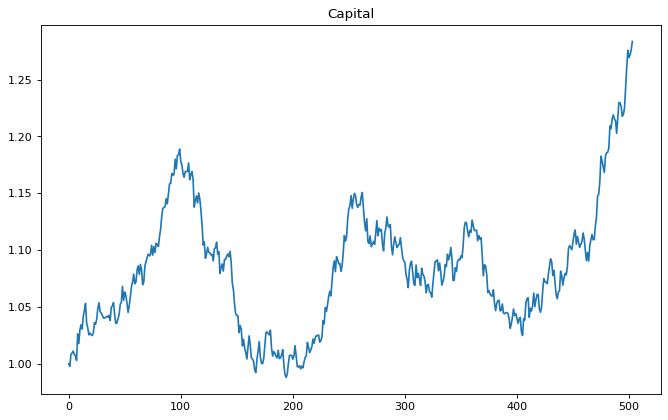

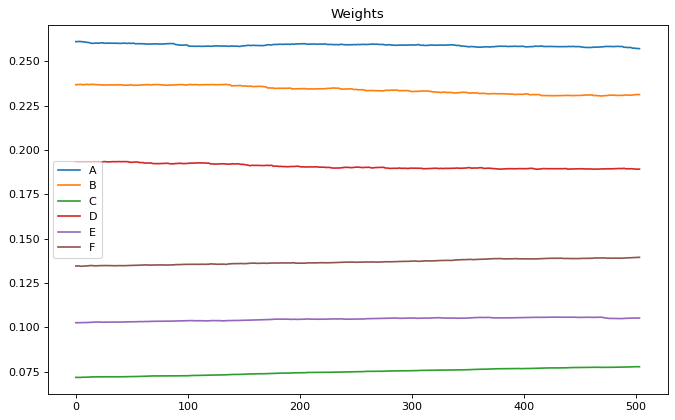

In [13]:
sharpe, capital, weights = grading(TRAIN, TEST)
#Sharpe gets printed to command line
print("Sharpe ratio: ",sharpe)
print("Weights: ", weights)

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Capital")
plt.plot(np.arange(len(TEST)), capital)
plt.show()

plt.figure(figsize=(10, 6), dpi=80)
plt.title("Weights")
plt.plot(np.arange(len(TEST)), weights)
plt.legend(TEST.columns)
plt.show()